In [1]:
import numpy as np
import scipy.io
from scipy.integrate import solve_ivp
import tensorflow as tf
from keras import backend as K
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as mtransforms

# imports custom RNCRN functions that are used throughout multiple  notebooks 
import os, sys 
from pathlib import Path
module_path = str(Path(os.path.abspath('')).parent)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from functions.target_systems import supercritical_hopf_normal_form 
from functions.RNCRN_tools import load_tf_models_params, save_crn, convert_static_exec_RNCRN_params_to_CRN, read_crn_txt, new_initial_conditions, stoch_mat_to_mass_action

In [2]:
# loads the previously trained model for quasi-static analysis 
filename = 'models/hopf_example'
matcontents = scipy.io.loadmat(filename+'.mat')
first_layer_weights = matcontents['first_layer_weights']
first_layer_biases = matcontents['first_layer_biases'][0]
output_layer_weights = matcontents['output_layer_weights']
N = len(matcontents['first_layer_biases'][0])
gamma = matcontents['gamma'][0][0]
beta_1 = matcontents['beta'][0][0]
tau = matcontents['alpha'][0][0] # abuse of notation - but intentional  

kernel_initializer_first = tf.keras.initializers.constant(matcontents['first_layer_weights'])
bias_initializer_first = tf.keras.initializers.constant(matcontents['first_layer_biases'][0])
kernel_initializer_second = tf.keras.initializers.constant(matcontents['output_layer_weights'])

def smooth_max_activation(x):
    return 0.5*(x + K.sqrt(K.square(x)+4*gamma*tau))/tau
get_custom_objects().update({'smooth_max_activation': Activation(smooth_max_activation)})

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,), name=''),
  tf.keras.layers.Dense(N, activation='smooth_max_activation', kernel_initializer=kernel_initializer_first, bias_initializer=bias_initializer_first),
  tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_initializer = kernel_initializer_second),
])


In [3]:
# loads the previously trained model for compilation into a chemical reaction network (using helper functions)
params, number_of_exec_species, number_of_chemical_perceptrons = load_tf_models_params(filename+'.mat')

# define the number of parameter species 
number_of_control_params = 1

# define time-scale parameter to rescale appropriate rate constants in the chemical reaction network
time_scale = 0.0075

# creates zero initial conditions for all chemical species (will be overwritten later)
inits = np.zeros(number_of_exec_species+number_of_chemical_perceptrons)
control_inits = np.zeros(number_of_control_params)

# location to store the CRN file for this RNCRN 
crn_file = 'CRNs/hopf_crn.txt'

# converts RNCRN parameters into a chemical reaction network and saves as a raw txt file 
save_crn(crn_file,  convert_static_exec_RNCRN_params_to_CRN(params, time_scale, inits, control_inits, number_of_exec_species, number_of_chemical_perceptrons, number_of_control_params) )

# reads the previously saved chemical reaction network file returning the key stoichiometry and kinetic matrices 
species, reaction_rates, react_stoch, prod_stoch, stoch_mat, number_species, number_reactions, initial_concs = read_crn_txt(crn_file)

# groups stoichiometry matrices for use in ODE simulation 
args_tup_rncrn = (reaction_rates, react_stoch, stoch_mat,)

In [4]:
# sets the executive species domain  
lower_limit = 3;
upper_limit = 7;
step_size = 0.25
x1_train = np.arange(lower_limit, upper_limit, step_size, dtype="float32")
x2_train = np.arange(lower_limit, upper_limit, step_size, dtype="float32")

# recall parameters used to shift the non-physical Hopf bifurication
a = 5;
r_critical = 2 

# offset amount for exploring non-perfect approximations 
slight_shift = 0.14

# sets the time length for the trajectory simulations 
tFinal = 250;

In [5]:
# numerical integrations of trajectories for the target system (shifted supercritical_hopf_normal_form) and the RNCRN approximation  
# these trajectories correspond to trajectories in Figure 2 (a)--(b)
# - TARGET SYSTEM 
inits = [2, 2];

#\lambda_1 = 1
args_tup = (a, r_critical, 1)
sol_1= solve_ivp(supercritical_hopf_normal_form, [0, tFinal], inits, args=args_tup, rtol=10e-8)

#\lambda_1 = 2
args_tup = (a, r_critical, 2)
sol_2= solve_ivp(supercritical_hopf_normal_form, [0, tFinal], inits, args=args_tup, rtol=10e-8)

#\lambda_3 = 2
args_tup = (a, r_critical, 3)
sol_3= solve_ivp(supercritical_hopf_normal_form, [0, tFinal], inits, args=args_tup, rtol=10e-8)

inits = [4.8, 4.3];
sol_3b= solve_ivp(supercritical_hopf_normal_form, [0, tFinal], inits, args=args_tup, rtol=10e-8)

# - RNCRN APPROXIMATION 
# helper functions new_initial_conditions and stoch_mat_to_mass_action are used to simulate general CRNs
# #\lambda_bar_1 = 1
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':2, 'X_2': 2, 'L_1': 1})
sol_rncrn_1 = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

# #\lambda_bar_1 = 2.14 (i.e. r_critical+slight_shift)
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':2, 'X_2': 2, 'L_1': r_critical+slight_shift})
sol_rncrn_2 = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

# #\lambda_bar_1 = 3
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':2, 'X_2': 2, 'L_1': 3})
sol_rncrn_3 = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)


In [6]:
# Vector fields for the target system (shifted supercritical_hopf_normal_form) and the quasi-static vector field for the RNCRN approximation  
# these vector fields correspond to the gray arrows in Figure 2 (a)--(b)

# \lambda_1 = 1 for target system vector field 
lambda_1 = 1
x3_train = np.array([lambda_1])
x1v, x2v, x3v = np.meshgrid(x1_train, x2_train, x3_train, indexing='ij')
D = x3v-r_critical -np.power(x1v-a, 2) -np.power(x2v-a, 2)
g_1 = D*(x1v-a) - (x2v-a)
g_2 = D*(x2v-a) + (x1v-a)
target_vf_x1_1 = np.transpose(g_1.reshape(g_1.shape[0],g_1.shape[1]))
target_vf_x2_1 = np.transpose(g_2.reshape(g_1.shape[0],g_1.shape[1]))

# \lambda_bar_1 = 1 for quasi-static RNCRN vector field 
x_train =  np.concatenate( (x1v.reshape(-1,1), x2v.reshape(-1,1), x3v.reshape(-1,1)), axis=1)
y_out = model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)
res_x1_1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
res_x2_1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))


# \lambda_1 = 2 for target system vector field 
lambda_1 = 2
x3_train = np.array([lambda_1])
x1v, x2v, x3v = np.meshgrid(x1_train, x2_train, x3_train, indexing='ij')
D = x3v-r_critical -np.power(x1v-a, 2) -np.power(x2v-a, 2)
g_1 = D*(x1v-a) - (x2v-a)
g_2 = D*(x2v-a) + (x1v-a)
target_vf_x1_2 = np.transpose(g_1.reshape(g_1.shape[0],g_1.shape[1]))
target_vf_x2_2 = np.transpose(g_2.reshape(g_1.shape[0],g_1.shape[1]))

# \lambda_1 = 2.14 for target system vector field 
lambda_1 = r_critical + slight_shift
x3_train = np.array([lambda_1])
x1v, x2v, x3v = np.meshgrid(x1_train, x2_train, x3_train, indexing='ij')
x_train =  np.concatenate( (x1v.reshape(-1,1), x2v.reshape(-1,1), x3v.reshape(-1,1)), axis=1)
y_out = model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)
res_x1_2 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
res_x2_2 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))

# \lambda_1 = 3 for target system vector field 
lambda_1 = 3
x3_train = np.array([lambda_1])
x1v, x2v, x3v = np.meshgrid(x1_train, x2_train, x3_train, indexing='ij')
D = x3v-r_critical -np.power(x1v-a, 2) -np.power(x2v-a, 2)
g_1 = D*(x1v-a) - (x2v-a)
g_2 = D*(x2v-a) + (x1v-a)
target_vf_x1_3 = np.transpose(g_1.reshape(g_1.shape[0],g_1.shape[1]))
target_vf_x2_3 = np.transpose(g_2.reshape(g_1.shape[0],g_1.shape[1]))

# \lambda_bar_1 = 3 for target system vector field 
x_train =  np.concatenate( (x1v.reshape(-1,1), x2v.reshape(-1,1), x3v.reshape(-1,1)), axis=1)
y_out = model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)
res_x1_3 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
res_x2_3 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))




8/8 [==============================] - 0s 857us/step


C:\Users\ad1114\AppData\Local\Temp\ipykernel_23240\860971139.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


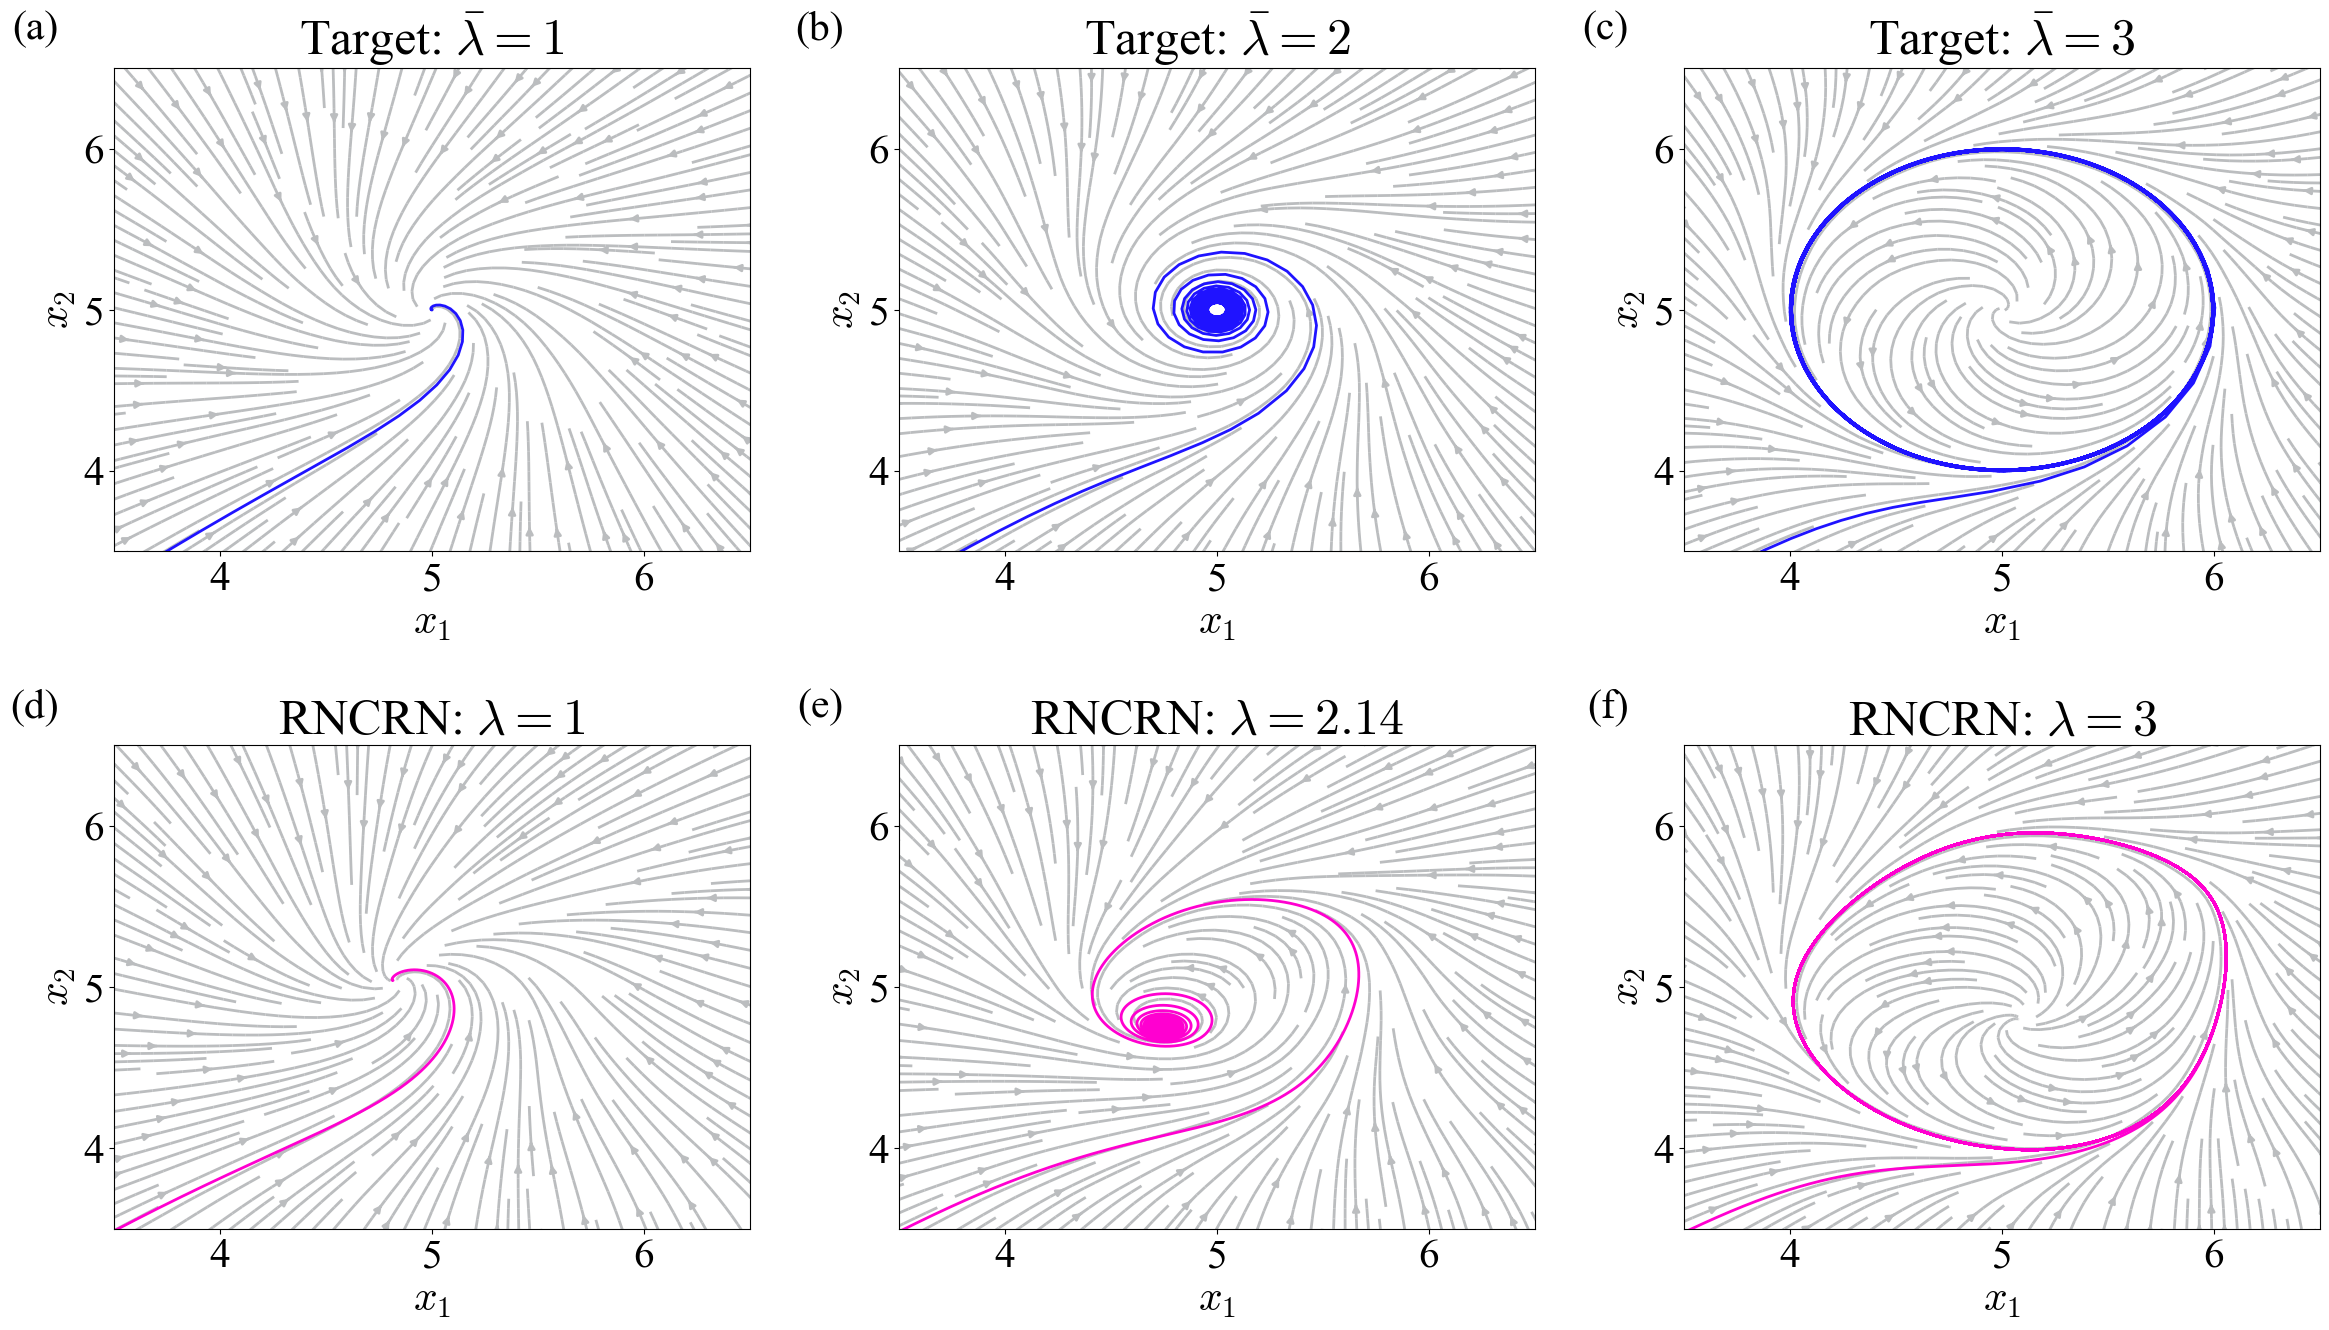

In [12]:
# plot some figures for visualisation  of the target system and RNCRN approximation  
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 30
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = [20 , 12]
mpl.rcParams['text.usetex'] = False
mpl.rcParams['legend.edgecolor'] = 'k'
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = False
ColList = ['#1F13FF','#FF00D0', '#2A2A72', '#A9A9A9']
mpl.rcParams['figure.figsize'] = [24, 14]

fig, axs = plt.subplot_mosaic([['(a)', '(b)', '(c)'],['(d)', '(e)', '(f)'],],  gridspec_kw={'width_ratios':[1,1,1]}, layout='constrained')

linestyle_nodes = '-'
ColList = ['#1F13FF', '#FF00D0', '#2A2A72', '#bbbdbf','#FFAD1F']
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30

tickfontsize=30
labelfontsize=35
titlefontsize=35  
legendfontsize = 20;
markersizeval = 10  

density = 1.5

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-40/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif', ha='right')


axa = axs['(a)']
axa.streamplot(x1_train, x2_train,target_vf_x1_1,target_vf_x2_1,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axa.set_xlim(lower_limit+0.5, upper_limit-0.5)
axa.set_ylim(lower_limit+0.5, upper_limit-0.5)
axa.plot(sol_1.y[0,:], sol_1.y[1,:], color=ColList[0], )
axa.set_title('Target: $\\bar{\lambda}=1$')
axa.set_xlabel('$x_1$')
axa.set_ylabel('$x_2$')
axa.set_xlim(3.5,6.5)
axa.set_ylim(3.5,6.5)

axb = axs['(b)']
axb.streamplot(x1_train, x2_train,target_vf_x1_2,target_vf_x2_2,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axb.set_xlim(lower_limit+0.5, upper_limit-0.5)
axb.set_ylim(lower_limit+0.5, upper_limit-0.5)
axb.plot(sol_2.y[0,:], sol_2.y[1,:], color=ColList[0], )
axb.set_title('Target: $\\bar{\lambda}=2$')
axb.set_xlabel('$x_1$')
axb.set_ylabel('$x_2$')
axb.set_xlim(3.5,6.5)
axb.set_ylim(3.5,6.5)

axc = axs['(c)']
axc.streamplot(x1_train, x2_train,target_vf_x1_3,target_vf_x2_3,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axc.set_xlim(lower_limit+0.5, upper_limit-0.5)
axc.set_ylim(lower_limit+0.5, upper_limit-0.5)
axc.plot(sol_3.y[0,:], sol_3.y[1,:], color=ColList[0], )
axc.set_title('Target: $\\bar{\lambda}=3$')
axc.set_xlabel('$x_1$')
axc.set_ylabel('$x_2$')
axc.set_xlim(3.5,6.5)
axc.set_ylim(3.5,6.5)

axd = axs['(d)']
axd.streamplot(x1_train, x2_train, res_x1_1, res_x2_1,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axd.plot(sol_rncrn_1.y[id_dict['X_1'],:], sol_rncrn_1.y[id_dict['X_2'],:], color=ColList[1], )
axd.set_xlim(lower_limit+0.5, upper_limit-0.5)
axd.set_ylim(lower_limit+0.5, upper_limit-0.5)
axd.set_xlabel('$x_1$')
axd.set_ylabel('$x_2$')
axd.set_title('RNCRN: $\lambda=1$')
axd.set_xlim(3.5,6.5)
axd.set_ylim(3.5, 6.5)

axe = axs['(e)']
axe.streamplot(x1_train, x2_train, res_x1_2, res_x2_2,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axe.plot(sol_rncrn_2.y[id_dict['X_1'],:], sol_rncrn_2.y[id_dict['X_2'],:], color=ColList[1], )
axe.set_xlim(lower_limit+0.5, upper_limit-0.5)
axe.set_ylim(lower_limit+0.5, upper_limit-0.5)
axe.set_xlabel('$x_1$')
axe.set_ylabel('$x_2$')
axe.set_title('RNCRN: $\lambda=2.14$')
axe.set_xlim(3.5,6.5)
axe.set_ylim(3.5,6.5)

axf = axs['(f)']
axf.streamplot(x1_train, x2_train, res_x1_3, res_x2_3,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axf.plot(sol_rncrn_3.y[id_dict['X_1'],:], sol_rncrn_3.y[id_dict['X_2'],:], color=ColList[1], )
axf.set_xlim(lower_limit+0.5, upper_limit-0.5)
axf.set_ylim(lower_limit+0.5, upper_limit-0.5)
axf.set_xlabel('$x_1$')
axf.set_ylabel('$x_2$')
axf.set_title('RNCRN: $\lambda=3$')
axf.set_xlim(3.5,6.5)
axf.set_ylim(3.5, 6.5)
plt.tight_layout()
plt.show()
#fig.savefig('figures/hopf_bifurcation.pdf', bbox_inches='tight')

In [8]:
#traj data
np.savetxt("data/hopf_traj_data_target_1.csv", np.asarray([ sol_1.t[:], sol_1.y[0,:], sol_1.y[1,:]]), delimiter=",")
np.savetxt("data/hopf_traj_data_target_2.csv", np.asarray([ sol_2.t[:], sol_2.y[0,:], sol_2.y[1,:]]), delimiter=",")
np.savetxt("data/hopf_traj_data_target_3.csv", np.asarray([ sol_3.t[:], sol_3.y[0,:], sol_3.y[1,:]]), delimiter=",")
np.savetxt("data/hopf_traj_data_rncrn_1.csv", np.asarray([ sol_rncrn_1.t[:], sol_rncrn_1.y[id_dict['X_1'],:], sol_rncrn_1.y[id_dict['X_2'],:]]), delimiter=",")
np.savetxt("data/hopf_traj_data_rncrn_2.csv", np.asarray([ sol_rncrn_2.t[:], sol_rncrn_2.y[id_dict['X_1'],:], sol_rncrn_2.y[id_dict['X_2'],:]]), delimiter=",")
np.savetxt("data/hopf_traj_data_rncrn_3.csv", np.asarray([ sol_rncrn_3.t[:], sol_rncrn_3.y[id_dict['X_1'],:], sol_rncrn_3.y[id_dict['X_2'],:]]), delimiter=",")

np.savetxt("data/hopf_x1_train.csv", x1_train, delimiter=",")
np.savetxt("data/hopf_x2_train.csv", x2_train, delimiter=",")

#target vfs
np.savetxt("data/hopf_target_vf_x1_1.csv", target_vf_x1_1, delimiter=",")
np.savetxt("data/hopf_target_vf_x2_1.csv", target_vf_x2_1, delimiter=",")
np.savetxt("data/hopf_target_vf_x1_2.csv", target_vf_x1_2, delimiter=",")
np.savetxt("data/hopf_target_vf_x2_2.csv", target_vf_x2_2, delimiter=",")
np.savetxt("data/hopf_target_vf_x1_3.csv", target_vf_x1_3, delimiter=",")
np.savetxt("data/hopf_target_vf_x2_3.csv", target_vf_x2_3, delimiter=",")

#RNCRN quasi-static vfs
np.savetxt("data/hopf_res_x1_1.csv", res_x1_1, delimiter=",")
np.savetxt("data/hopf_res_x2_1.csv", res_x2_1, delimiter=",")
np.savetxt("data/hopf_res_x1_2.csv", res_x1_2, delimiter=",")
np.savetxt("data/hopf_res_x2_2.csv", res_x2_2, delimiter=",")
np.savetxt("data/hopf_res_x1_3.csv", res_x1_3, delimiter=",")
np.savetxt("data/hopf_res_x2_3.csv", res_x2_3, delimiter=",")
 

In [9]:
# show rates used (also stated in the Appendix)
alpha_mat, omega_mat, bias_vec, beta, gamma, tau = params
print('omega_1')
for val in omega_mat[:,0]:
    print(f'{val:.3f}', '\\\\')

print('omega_2')
for val in omega_mat[:,1]:
    print(f'{val:.3f}', '\\\\')
    
print('psi_1')
for val in omega_mat[:,2]:
    print(f'{val:.3f}', '\\\\')
    
print('alpha_mat_1')
for val in alpha_mat[0,:]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_2')
for val in alpha_mat[1,:]:
    print(f'{val:.3f}', '\\\\')
    
print('bias_vec')
for val in bias_vec:
    print(f'{val[0]:.3f}', '\\\\')

omega_1
-1.298 \\
-0.228 \\
-1.545 \\
0.103 \\
-2.239 \\
omega_2
-0.599 \\
-0.131 \\
0.061 \\
-0.940 \\
1.676 \\
psi_1
0.105 \\
-0.080 \\
0.070 \\
0.039 \\
0.069 \\
alpha_mat_1
-4.315 \\
-5.861 \\
-9.788 \\
3.796 \\
-1.209 \\
alpha_mat_2
-1.505 \\
-4.968 \\
0.149 \\
-25.501 \\
0.824 \\
bias_vec
10.656 \\
8.520 \\
5.385 \\
3.369 \\
4.653 \\


In [10]:
print('parameter species weights')
for val in omega_mat[:,2]:
    print(f'{val:.3f}', '\\\\')

parameter species weights
0.105 \\
-0.080 \\
0.070 \\
0.039 \\
0.069 \\


In [11]:
# Approximate quasi-static error
print('(x1, r=-1)', np.mean(np.square(target_vf_x1_1-res_x1_1)))
print('(x2, r=-1)', np.mean(np.square(target_vf_x2_1-res_x2_1)))

print('(x1, r=0)', np.mean(np.square(target_vf_x1_2-res_x1_2)))
print('(x2, r=0)', np.mean(np.square(target_vf_x2_2-res_x2_2)))

print('(x1, r=1)', np.mean(np.square(target_vf_x1_3-res_x1_3)))
print('(x2, r=1)', np.mean(np.square(target_vf_x2_3-res_x2_3)))

(x1, r=-1) 1.33897667630481
(x2, r=-1) 1.4343877140672703
(x1, r=0) 1.4669259031097681
(x2, r=0) 1.605680462809687
(x1, r=1) 1.5355859200672057
(x2, r=1) 1.7723830015575004
